# Fine Tuning Inception v3

In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
import cv2

from sklearn.utils import shuffle

import visualize

from sklearn import svm


from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix


from sklearn.svm import LinearSVC

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import pickle

In [2]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
from keras.optimizers import SGD
import keras.backend as K

Using TensorFlow backend.


In [2]:
# load images names, create a data frame with the columns [img name, label, and path]
file_names = glob.glob('NWPU-RESISC45/*/*')
file_names_df = [i.split('/')[1:] for i in file_names]
file_names_df = pd.DataFrame(file_names_df, columns=['label','img_name'])
file_names_df['full_img_path'] = file_names

In [4]:
# this stores the initial weights from the model to be tuned 
inception_v3_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(256,256,3), pooling='max')
# the model to be tuned
fine_tune_inception_v3_model = InceptionV3(include_top=True, weights=None, input_shape=(256,256,3),classes=45)
# this will copy the weights from the prev model after it gets fine tuned
feature_extractor_inception_v3_model = InceptionV3(include_top=False, weights=None, input_shape=(256,256,3), pooling='max')


In [5]:
images = np.array(file_names_df['full_img_path'].apply(lambda i: cv2.imread(i)).tolist()).astype(np.float32)

In [6]:
preprocessed_imgs = inception_preprocess_input(images)
labels = np.array(file_names_df['label'])

In [7]:
num_classes = 45
batch_size = 32 
nb_epoch = 3

In [8]:
#convert labels to one-hot encoded labels
le = LabelEncoder().fit(labels)
ohe = OneHotEncoder(sparse=False).fit(le.transform(labels).reshape(len(labels),1))

one_hot_labels = ohe.transform(le.transform(labels).reshape(len(labels),1))

In [9]:
accuracies = {}
confusion_matrices = {}

#fune tune, train and test for each train size settings for 5 times
for test_size in [.9, .8]:
    print 'test size (proportion): '+str(test_size)
    
    accuracies[str(test_size)] = []
    confusion_matrices[str(test_size)] = []
    
    splitter = ShuffleSplit(n_splits=5, test_size=test_size, random_state=0)

    for train_index, test_index in tqdm(splitter.split(preprocessed_imgs)):
        
        # split data for deep learning fine tuning
        X_train, y_train = preprocessed_imgs[train_index], one_hot_labels[train_index]

        # set the weights to the pre-trained weights
        fine_tune_inception_v3_model.set_weights(inception_v3_model.get_weights())
        
        # renitialize the last layer (dense layer)
        session = K.get_session()
        fine_tune_inception_v3_model.layers[-1].kernel.initializer.run(session=session)
        
        sgd = SGD(lr=0.001, decay=0.0005, momentum=0.9)
        fine_tune_inception_v3_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
        fine_tune_inception_v3_model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, \
                  shuffle=True, verbose=0, validation_data=None)
        
        # end of fine tuning
        #########
        

        # set the weights to the fine-tuned model
        feature_extractor_inception_v3_model.set_weights(fine_tune_inception_v3_model.get_weights())
        
        # extract features for train and test
        X_train = feature_extractor_inception_v3_model.predict(X_train)
        X_test = feature_extractor_inception_v3_model.predict(preprocessed_imgs[test_index])
        
        y_train = labels[train_index]
        y_test = labels[test_index]
        
        svm = LinearSVC(random_state=0)
        svm.fit(X_train, y_train)
        
        y_hat = svm.predict(X_test)

        accuracy = accuracy_score(y_test, y_hat)
        cfnm = confusion_matrix(y_test, y_hat)
        
        accuracies[str(test_size)].append(accuracy)
        confusion_matrices[str(test_size)].append(cfnm)
                
    print np.mean(accuracies[str(test_size)])

0it [00:00, ?it/s]

test size (proportion): 0.9
Epoch 1/3
3150/3150 [==============================] - 110s - loss: 3.1344 - acc: 0.2765   
Epoch 2/3
3150/3150 [==============================] - 103s - loss: 1.4264 - acc: 0.7378   
Epoch 3/3
3150/3150 [==============================] - 103s - loss: 0.6637 - acc: 0.8825   


1it [11:24, 684.62s/it]

Epoch 1/3
3150/3150 [==============================] - 106s - loss: 3.1600 - acc: 0.2708   
Epoch 2/3
3150/3150 [==============================] - 102s - loss: 1.4437 - acc: 0.7429   
Epoch 3/3
3150/3150 [==============================] - 102s - loss: 0.7052 - acc: 0.8660   


2it [22:40, 680.24s/it]

Epoch 1/3
3150/3150 [==============================] - 107s - loss: 3.1903 - acc: 0.2606   
Epoch 2/3
3150/3150 [==============================] - 103s - loss: 1.4546 - acc: 0.7438   
Epoch 3/3
3150/3150 [==============================] - 103s - loss: 0.6933 - acc: 0.8762   


3it [33:57, 679.00s/it]

Epoch 1/3
3150/3150 [==============================] - 107s - loss: 3.1488 - acc: 0.2759   
Epoch 2/3
3150/3150 [==============================] - 103s - loss: 1.4265 - acc: 0.7429   
Epoch 3/3
3150/3150 [==============================] - 103s - loss: 0.6950 - acc: 0.8724   


4it [45:17, 679.46s/it]

Epoch 1/3
3150/3150 [==============================] - 107s - loss: 3.2205 - acc: 0.2492   
Epoch 2/3
3150/3150 [==============================] - 103s - loss: 1.4963 - acc: 0.7425   
Epoch 3/3
3150/3150 [==============================] - 102s - loss: 0.7112 - acc: 0.8660   


5it [57:46, 693.40s/it]
0it [00:00, ?it/s]

0.794610229277
test size (proportion): 0.8
Epoch 1/3
6300/6300 [==============================] - 213s - loss: 2.4203 - acc: 0.4641   
Epoch 2/3
6300/6300 [==============================] - 206s - loss: 0.7477 - acc: 0.8267   
Epoch 3/3
6300/6300 [==============================] - 205s - loss: 0.3688 - acc: 0.9179   


1it [16:35, 995.51s/it]

Epoch 1/3
6300/6300 [==============================] - 211s - loss: 2.4267 - acc: 0.4598   
Epoch 2/3
6300/6300 [==============================] - 206s - loss: 0.7280 - acc: 0.8333   
Epoch 3/3
6300/6300 [==============================] - 205s - loss: 0.3501 - acc: 0.9230   


2it [33:47, 1013.73s/it]

Epoch 1/3
6300/6300 [==============================] - 210s - loss: 2.4376 - acc: 0.4562   
Epoch 2/3
6300/6300 [==============================] - 206s - loss: 0.7231 - acc: 0.8327   
Epoch 3/3
6300/6300 [==============================] - 206s - loss: 0.3524 - acc: 0.9160   


3it [54:22, 1087.45s/it]

Epoch 1/3
6300/6300 [==============================] - 214s - loss: 2.4590 - acc: 0.4470   
Epoch 2/3
6300/6300 [==============================] - 206s - loss: 0.7637 - acc: 0.8227   
Epoch 3/3
6300/6300 [==============================] - 206s - loss: 0.3649 - acc: 0.9190   


4it [1:13:07, 1096.95s/it]

Epoch 1/3
6300/6300 [==============================] - 212s - loss: 2.4439 - acc: 0.4562   
Epoch 2/3
6300/6300 [==============================] - 206s - loss: 0.7523 - acc: 0.8210   
Epoch 3/3
6300/6300 [==============================] - 206s - loss: 0.3778 - acc: 0.9103   


5it [1:29:59, 1079.99s/it]

0.862142857143


In [5]:
print 'accuracies of Inception V3 model'
for key in accuracies.keys():
    accuracy = np.mean(accuracies[key])
    print 'test size is '+key
    print 'accuracy for is '+str(accuracy)+' +/- '+str(np.std(accuracies[key]))

    print

accuracies of Inception V3 model
test size is 0.9
accuracy for is 0.794610229277 +/- 0.00352771779248

test size is 0.8
accuracy for is 0.862142857143 +/- 0.00187308313035



In [3]:
classes = file_names_df['label'].unique().tolist()
classes = sorted(classes)

Normalized confusion matrix


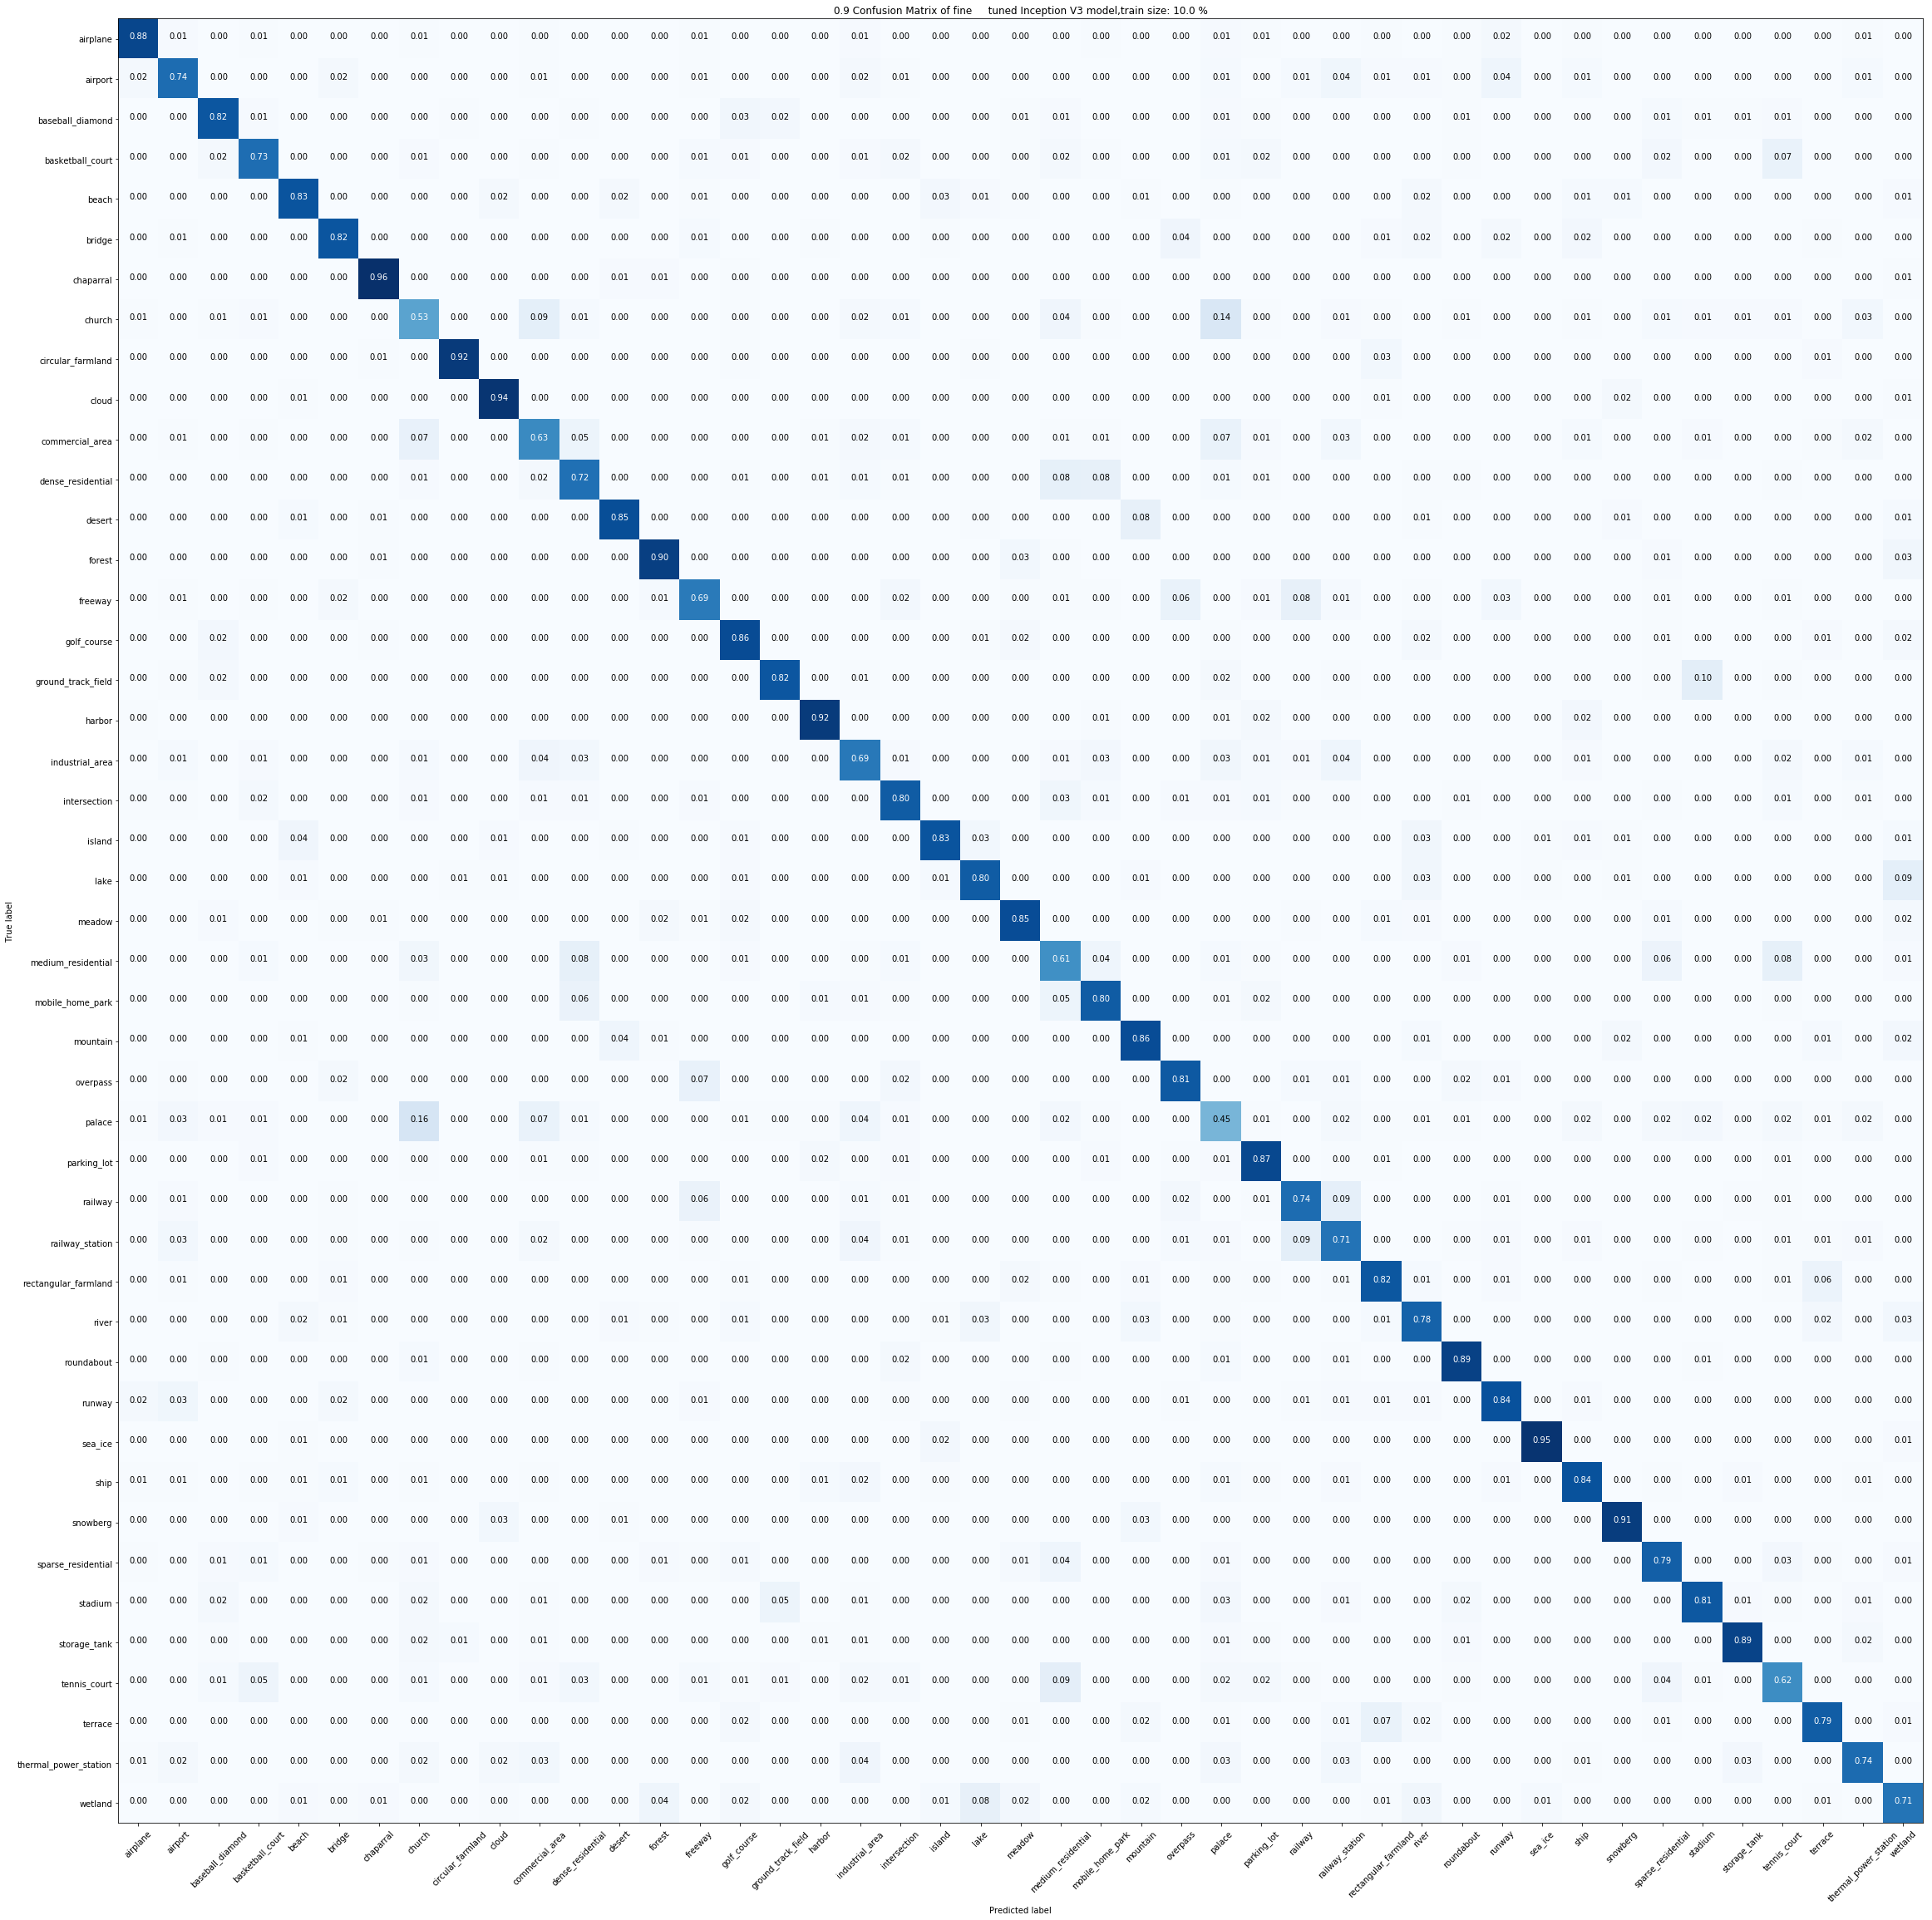

Normalized confusion matrix


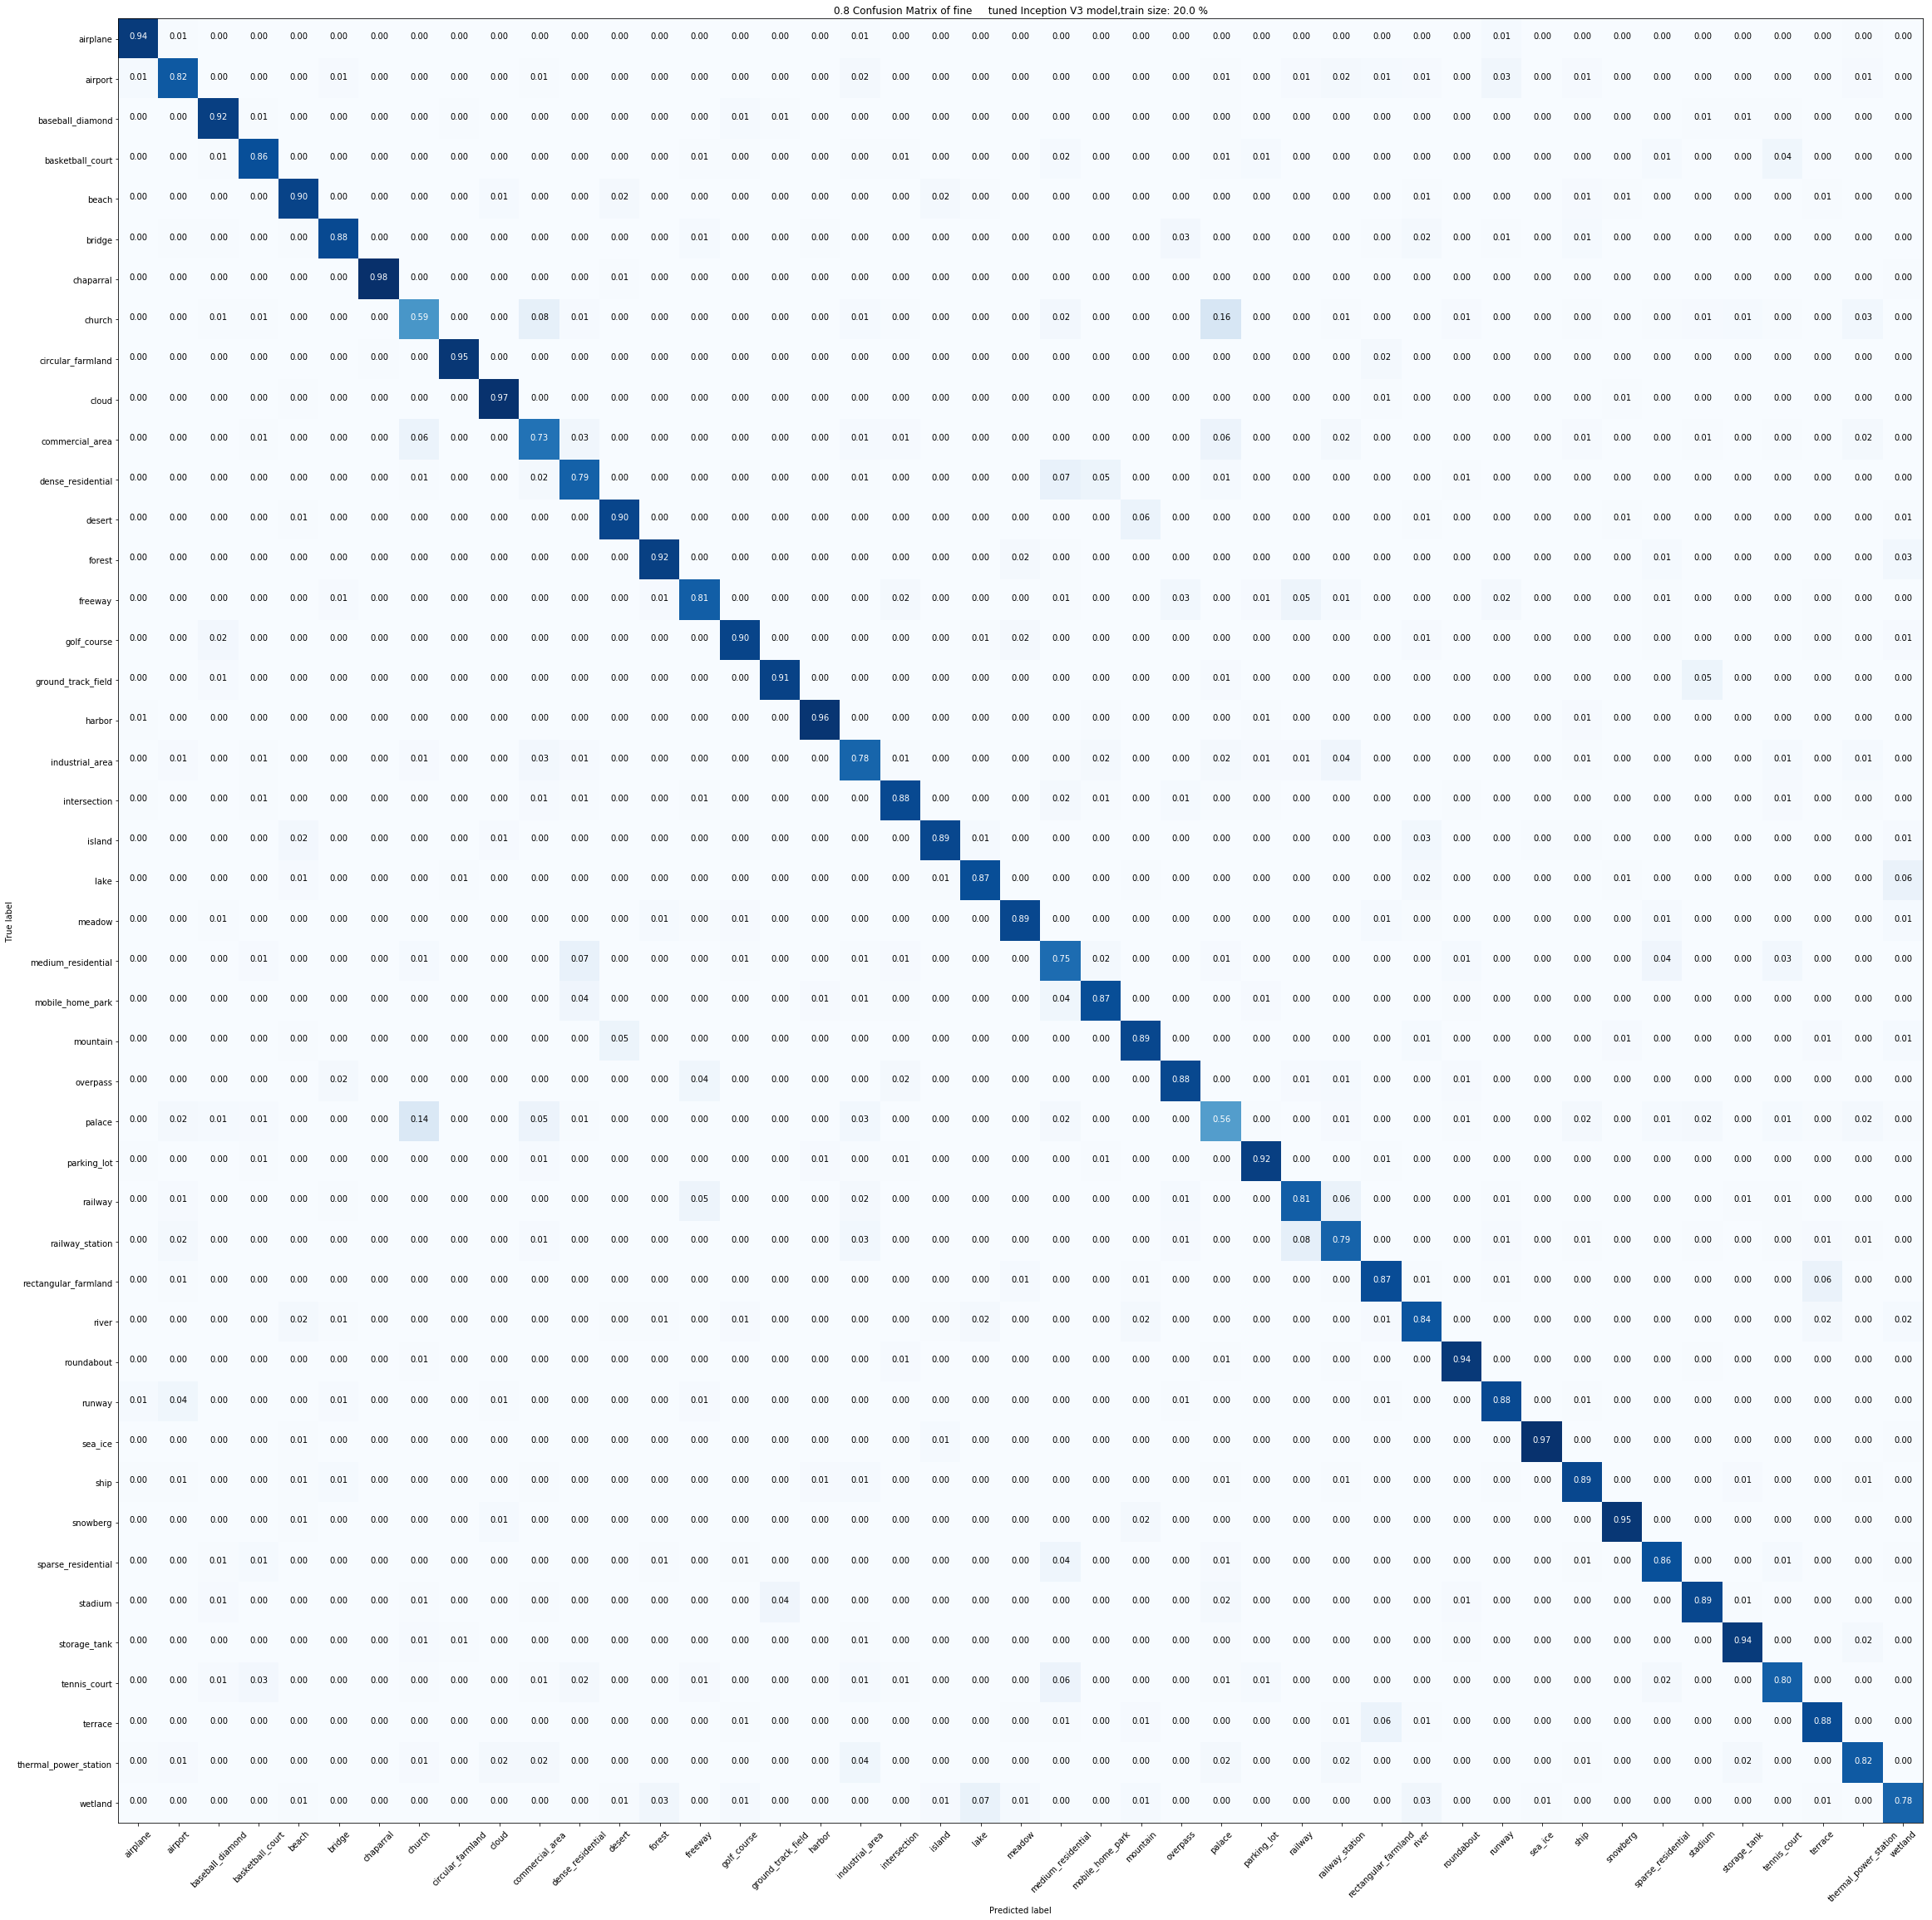

In [7]:
#plot confusion matrices
for key in accuracies.keys():
    cmfn = np.sum(confusion_matrices[key], axis=0)
    visualize.plot_confusion_matrix(cmfn, classes, normalize=True, title=key+' Confusion Matrix of fine \
    tuned Inception V3 model,'+'train size: '+str((1-float(key))*100)+ ' %')
    plt.show()